# Quickstart


`AutoEmulate`'s goal is to make it easy to create an emulator for your simulation. Here's the basic workflow:


In [1]:
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.experimental.emulators import *

from autoemulate.experimental.simulations.projectile import Projectile

import warnings
warnings.filterwarnings("ignore")

## Design of Experiments

Before we build an emulator or surrogate model, we need to get a set of input/output pairs from the simulation. This is called the **Design of Experiments (DoE)** and is currently not a key part of `AutoEmulate`, as this step is tricky to automate and will run on more complex compute infrastructure for expensive simulations. There are lots of sampling techniques, but here we are using Latin Hypercube Sampling.

Below, `simulate_projectile` is a simulation for a projectil motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). It takes two inputs, the drag coefficient (on a log scale) and the velocity and outputs the distance the projectile travelled. We sample 100 sets of inputs `X` using a Latin Hypercube Sampler and run the simulator for those inputs to get the outputs `y`.


In [2]:
projectile = Projectile()

# sample from a simulation
n_samples = 500
x = projectile.sample_inputs(n_samples).float()
y = projectile.forward_batch(x).float()

x.shape, y.shape

Running simulations: 100%|██████████| 500/500 [00:00<00:00, 1261.86it/s]

Successfully completed 500/500 simulations (100.0%)


(torch.Size([500, 2]), torch.Size([500, 1]))

## Comparing emulators

This is the core of `AutoEmulate`. With a set of inputs / outputs, we can run a full machine learning pipeline, including data processing, model fitting, model selection and potentially hyperparameter optimisation in just a few lines of code. First, let's check the names of the available emulators.


In [3]:
# Print list of available emulators
AutoEmulate.list_emulators()

,model_name,short_name
0,GaussianProcessExact,GPE
1,GaussianProcessExactCorrelated,GPEC
2,LightGBM,LGBM
3,SupportVectorMachine,SVM
4,RadialBasisFunctions,RBF
5,RandomForest,RF
6,MLP,MLP
7,EnsembleMLP,EMLP
8,EnsembleMLPDropout,EMLPD


Now let's initialise an `AutoEmulate` object. This provides the simulation inputs and outputs, then fits a range of different models to the data and evaluates on test witheld test data.

In [ ]:
ae = AutoEmulate(
    x,
    y,
    n_iter=50,
    n_splits=2,
    shuffle=True,
    # models=[MLP, GaussianProcessExact],  # Omitting this will use all available emulators
)

100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Look at the summary for a comparison of emulator performace.

In [4]:
ae.summarise()

,id,model_name,x_transforms,y_transforms,rmse_score,r2_score
0,MLP1,MLP,[StandardizeTransform()],[StandardizeTransform()],11364867.0,0.789279
1,GPE2,GaussianProcessExact,[StandardizeTransform()],[StandardizeTransform()],30901448.0,0.239702


Choose an emulator id from the summary list or quickly get the best (based on `r2_score`).

In [ ]:
best = ae.best_result()
best.id

'MLP1'

Plot the emulator predictions against the simulator outputs.

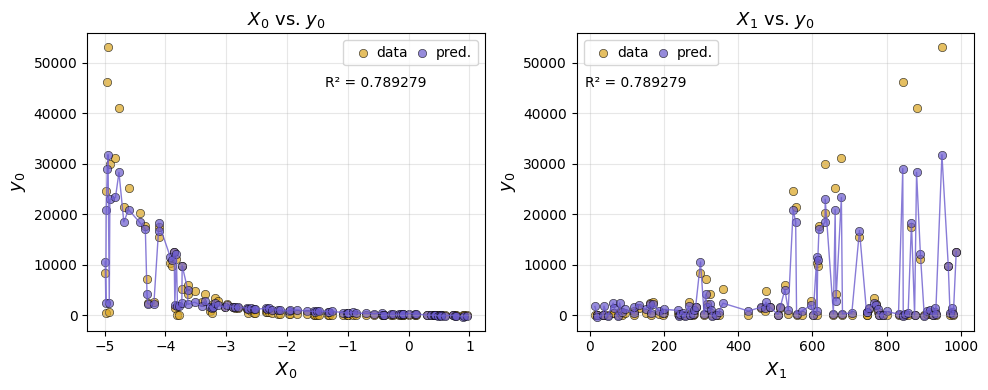

In [6]:
ae.plot(best.id)

## Predictions

We can use the model to make predictions for new inputs. Emulators in `AutoEmulate` can use the `predict` method to make predictions.


In [7]:
best.model.predict(x[:10])

tensor([[  471.3840],
        [12074.1377],
        [14782.7246],
        [  763.6697],
        [11537.9424],
        [ 2133.5430],
        [  160.4797],
        [ 2241.4216],
        [ 1411.3809],
        [ 2346.2114]])